# Summary and Plot the result

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import pandas as pd
import numpy as np
import os

from utils import *

plt.style.use(['science', 'ieee'])

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

## Dependent Noise results

In [29]:
def plot_metric_props(metric_name, node_num, seeds=None, flow_types=['IAF', 'DAGGNN'], dep_props=[10,30,50,80]):
    """
    Plot the metric for different dependence proportions and flow types.
    Args:
        metric_name (str): Name of the metric. ('FDR', 'TPR', 'FPR', 'SHD', 'Predicted Edges')
        node_num (int): Number of nodes.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    colors = ['tab:blue', 'tab:orange', 'tab:green']

    res_fdr = np.zeros((len(dep_props), len(flow_types)))
    res_tpr = np.zeros((len(dep_props), len(flow_types)))
    res_fpr = np.zeros((len(dep_props), len(flow_types)))
    res_shd = np.zeros((len(dep_props), len(flow_types)))
    res_nnz = np.zeros((len(dep_props), len(flow_types)))

    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]
    
    for j, dep_prop in enumerate(dep_props):
        for k, flow_type in enumerate(flow_types):
            fs = [f for f in folders if f'_{flow_type}_node{node_num}_prop{dep_prop}' in f]

            if seeds is not None:
                fs = [f for f in fs if int(f.split('_')[5][4:]) in seeds]

            cnt = 0
            for f in fs:
                if 'predG.txt' in os.listdir(f'results/dependence/{f}'):
                    pred_G = np.loadtxt(f'results/dependence/{f}/predG.txt', delimiter=' ').reshape(node_num, node_num)

                    if metric_name == 'Predicted Edges':
                        pred_G = np.loadtxt(f'results/dependence/{f}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

                    if np.isnan(pred_G).any():
                        continue
                    true_G = np.loadtxt(f'results/dependence/{f}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
                    pred_G[np.abs(pred_G) < 0.3] = 0
                    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))
                        
                    res_fdr[j, k] += fdr
                    res_tpr[j, k] += tpr
                    res_fpr[j, k] += fpr
                    res_shd[j, k] += shd
                    res_nnz[j, k] += nnz
                    cnt += 1

            if cnt == 0:
                continue
            res_fdr[j, k] /= cnt
            res_tpr[j, k] /= cnt
            res_fpr[j, k] /= cnt
            res_shd[j, k] /= cnt
            res_nnz[j, k] /= cnt

    all_res = {'FDR' : res_fdr, 'TPR' : res_tpr, 'FPR' : res_fpr, 'SHD' : res_shd, 'Predicted Edges' : res_nnz}
    res = all_res[metric_name]

    for k, flow_type in enumerate(flow_types):
        ax.plot(dep_props, res[:, k], label=flow_type, marker='o', color=colors[k], linestyle='--')
    ax.set_xlabel('Dependence Proportion')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} for {node_num} Nodes')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{metric_name}_dependence_{node_num}.pdf')

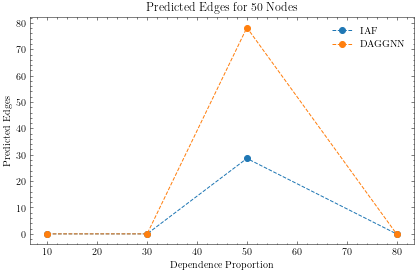

In [30]:
plot_metric_props('Predicted Edges', 50, [11,21,31,41,51])

In [34]:
def plot_metric_nodes(metric_name, dep_prop, node_nums=[10,20,30,50], seeds=None, flow_types=['IAF','DAGGNN']):
    """
    Plot the metric for different node numbers and flow types, with fixed dependence proportion.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    colors = ['tab:blue', 'tab:orange', 'tab:green']

    res_fdr = np.zeros((len(node_nums), len(flow_types)))
    res_tpr = np.zeros((len(node_nums), len(flow_types)))
    res_fpr = np.zeros((len(node_nums), len(flow_types)))
    res_shd = np.zeros((len(node_nums), len(flow_types)))
    res_nnz = np.zeros((len(node_nums), len(flow_types)))

    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]

    for i, node_num in enumerate(node_nums):
        for k, flow_type in enumerate(flow_types):
            fs = [f for f in folders if f'_{flow_type}_node{node_num}_prop{dep_prop}' in f]

            if seeds is not None:
                fs = [f for f in fs if int(f.split('_')[5][4:]) in seeds]

            cnt = 0
            for f in fs:
                if 'predG.txt' in os.listdir(f'results/dependence/{f}'):
                    pred_G = np.loadtxt(f'results/dependence/{f}/predG.txt', delimiter=' ').reshape(node_num, node_num)

                    if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/dependence/{f}'):
                        pred_G = np.loadtxt(f'results/dependence/{f}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

                    if np.isnan(pred_G).any():
                        continue
                    true_G = np.loadtxt(f'results/dependence/{f}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
                    pred_G[np.abs(pred_G) < 0.3] = 0
                    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))
                        
                    res_fdr[i, k] += fdr
                    res_tpr[i, k] += tpr
                    res_fpr[i, k] += fpr
                    res_shd[i, k] += shd
                    res_nnz[i, k] += nnz
                    cnt += 1

            if cnt == 0:
                continue

            res_fdr[i, k] /= cnt
            res_tpr[i, k] /= cnt
            res_fpr[i, k] /= cnt
            res_shd[i, k] /= cnt
            res_nnz[i, k] /= cnt

    all_res = {'FDR' : res_fdr, 'TPR' : res_tpr, 'FPR' : res_fpr, 'SHD' : res_shd, 'Predicted Edges' : res_nnz}
    res = all_res[metric_name]

    for k, flow_type in enumerate(flow_types):
        ax.plot(node_nums, res[:, k], label=flow_type, marker='o', color=colors[k], linestyle='--')
    ax.set_xlabel('Node Number')
    ax.set_ylabel(metric_name)

    ax.set_title(f'{metric_name} for Dependence Proportion {dep_prop}%')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{metric_name}_dependence_{dep_prop}.pdf')

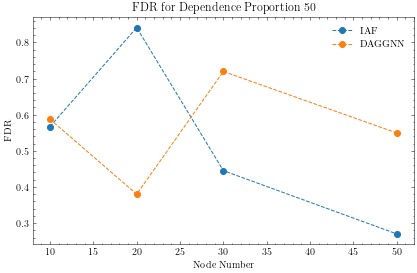

In [35]:
plot_metric_nodes('FDR', 50)

In [120]:
def plot_comparison(node_num, dep_prop):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for idx in range(len(flow_types)):
        folder = [f for f in folders if f.endswith(f'{flow_types[idx]}_node{node_num}_prop{dep_prop}')][0]
        pred_G = np.loadtxt(f'results/dependence/{folder}/predG.txt', delimiter=' ').reshape(node_num, node_num)
        true_G = np.loadtxt(f'results/dependence/{folder}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
        pred_G[np.abs(pred_G) < 0.3] = 0
        if idx == 0:
            sns.heatmap(true_G, cmap=newcmp, ax=axes[0, 0], vmin=-2, vmax=2, cbar=False)
            axes[0, 0].set_title('True Graph', fontsize=20)
            for _, spine in axes[0, 0].spines.items():
                spine.set_visible(True)
            axes[0, 0].set_xticks([])
            axes[0, 0].set_yticks([])
        sns.heatmap(pred_G, cmap=newcmp, ax=axes.ravel()[idx+1], vmin=-2, vmax=2, cbar_ax = cbar_ax if idx == 0 else None, cbar = (idx == 0))
        axes.ravel()[idx+1].set_title('Preidcted Graph: ' + flow_types[idx], fontsize=20)
        for _, spine in axes.ravel()[idx+1].spines.items():
            spine.set_visible(True)
        axes.ravel()[idx+1].set_xticks([])
        axes.ravel()[idx+1].set_yticks([])

    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'plots/comparison_dep_{node_num}_{dep_prop}.pdf')

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_13849/1640629237.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


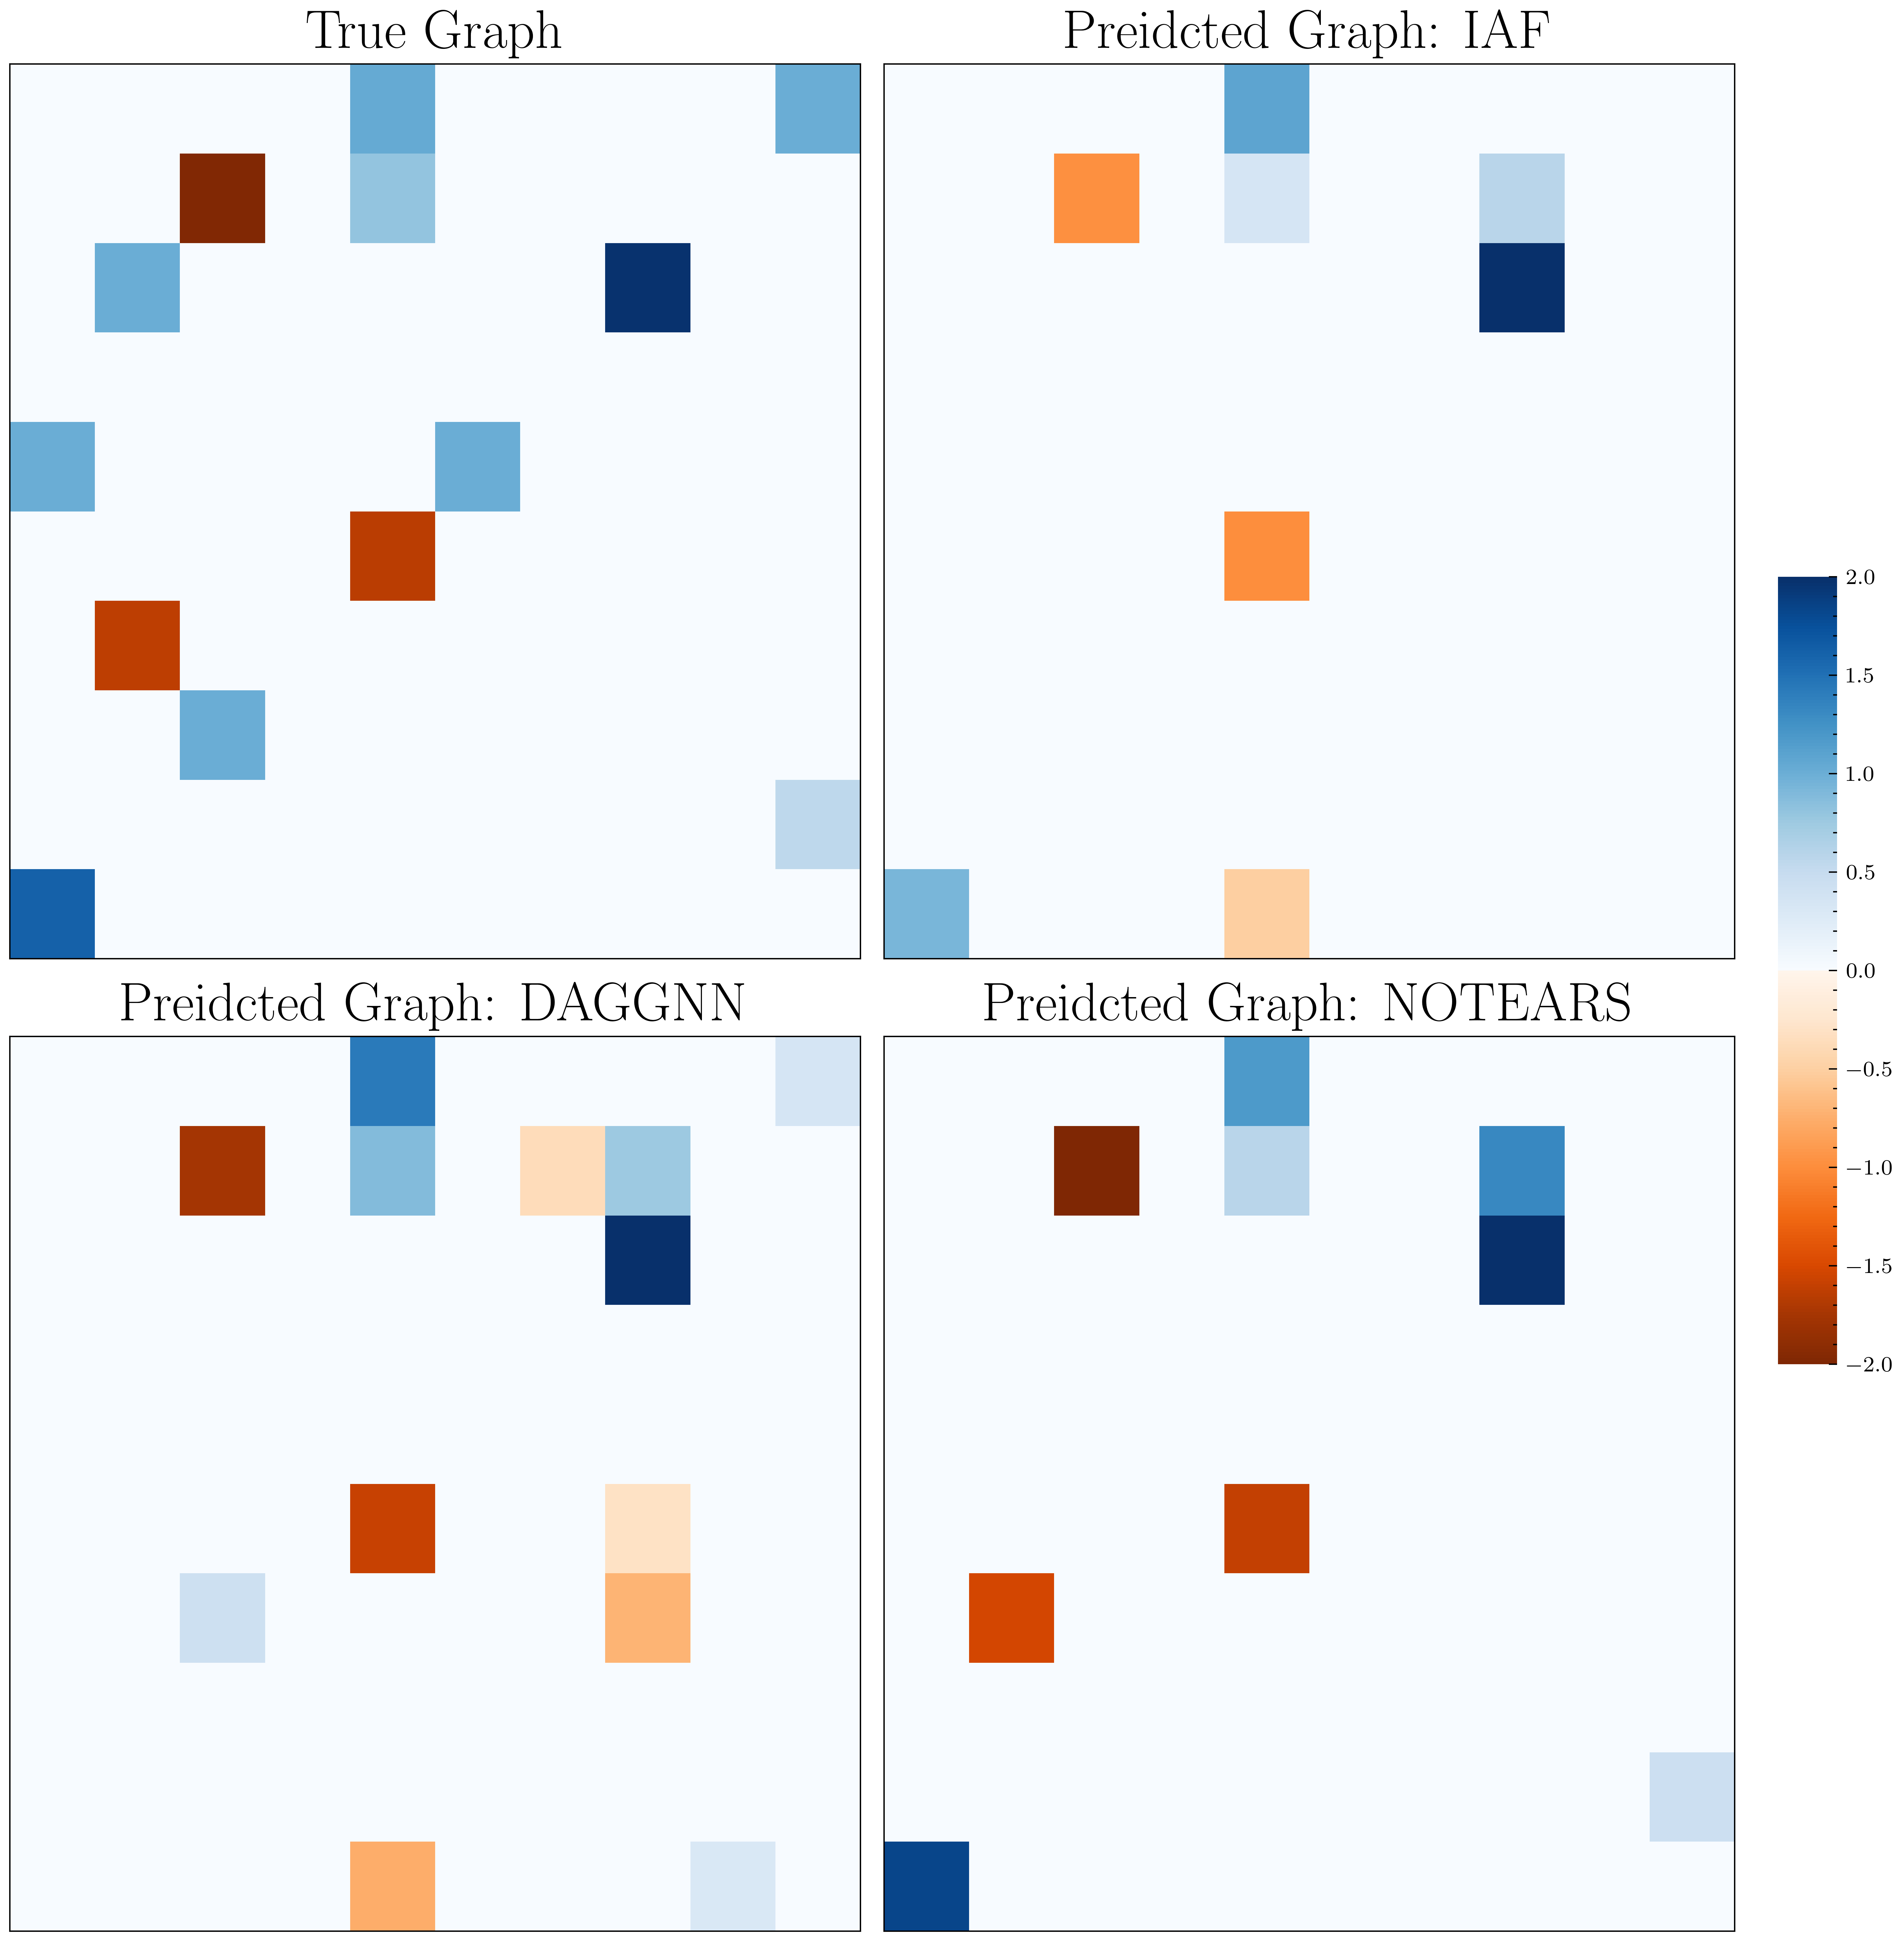

In [121]:
plot_comparison(10, 70)